In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/MyDrive/', force_remount = True)


Mounted at /content/MyDrive/


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')


Num GPUs Available:  1


In [4]:
!pwd

/content


In [5]:
!ls


MyDrive  sample_data


In [6]:
%cd MyDrive/MyDrive/Colab Notebooks/

/content/MyDrive/MyDrive/Colab Notebooks


In [7]:
!pip install split-folders

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.applications import EfficientNetB3
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, classification_report
from sklearn.model_selection import train_test_split
from imutils import paths

import matplotlib.pyplot as plt
import seaborn as sb
import splitfolders
import cv2
import random

In [10]:
inputFolder = './image_dataset_(Brain)'
outputFolder = './image_dataset_(Brain)_output'

In [11]:
splitfolders.ratio(inputFolder, outputFolder, seed = 44, ratio = (0.8, 0.0, 0.2))

Copying files: 0 files [00:01, ? files/s]


In [12]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sb
from imutils import paths

trainFolder = os.path.join(inputFolder, 'train')
testFolder = os.path.join(inputFolder, 'test')

# Get image paths separately for train and test
train_imgPaths = list(paths.list_images(trainFolder))
test_imgPaths = list(paths.list_images(testFolder))

print(f"Train images: {len(train_imgPaths)}")
print(f"Test images: {len(test_imgPaths)}")

# Shuffle paths
random.shuffle(train_imgPaths)
random.shuffle(test_imgPaths)

# Get class names dynamically from train folder
classes = sorted(os.listdir(trainFolder))  # safer and dynamic
print("Classes:", classes)

IMGSIZE = 128

X_train, y_train, img_names = [], [], []
X_test, y_test = [], []

# Processing training data
for imgPath in train_imgPaths:
    className = imgPath.split(os.path.sep)[-2]
    # img = cv2.imread(imgPath)
    # print(f"Processing: {imgPath}")
    img = cv2.imread(imgPath)
    if img is None:
        print(f"Warning: Failed to read image {imgPath}")
        continue  # skip this image

    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    X_train.append(img)
    y_train.append(classes.index(className))
    img_names.append(os.path.basename(imgPath))

# Processing testing data
for imgPath in test_imgPaths:
    className = imgPath.split(os.path.sep)[-2]
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    X_test.append(img)
    y_test.append(classes.index(className))

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

Train images: 16100
Test images: 4000
Classes: ['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']
16100 16100
4000 4000


In [13]:
df = pd.DataFrame({
    'File Name' : img_names,
    'Category' : y_train #y
})

# print(classes.index('brain_menin'))
# print(classes.index('brain_glioma'))
# print(classes.index('brain_pituitary'))
# print(classes.index('no_tumor'))

print(classes)
df.head()


['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


,File Name,Category
0,brain_menin_4658.jpg,1
1,no_tumor_train_0336.jpg,3
2,brain_menin_4800.jpg,1
3,brain_menin_4757.jpg,1
4,brain_tumor_0369.jpg,2


<Axes: ylabel='count'>

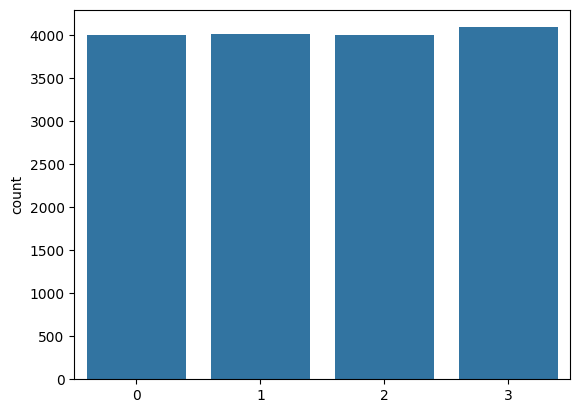

In [14]:
sb.countplot(x = y_train)

<Axes: ylabel='count'>

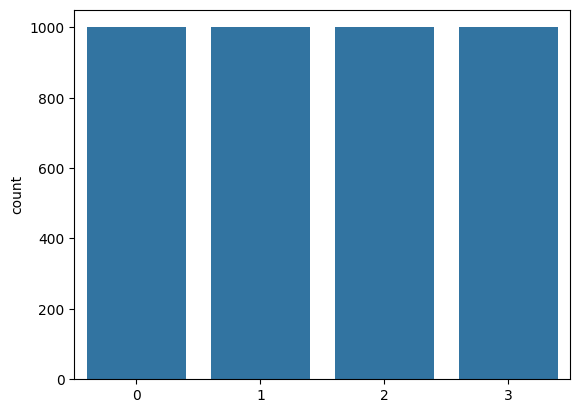

In [15]:
sb.countplot(x = y_test)

In [16]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16100, 128, 128, 3) (16100,)
(4000, 128, 128, 3) (4000,)


In [18]:
input_shape = (IMGSIZE, IMGSIZE, 3) #tuple
num_classes = 4

# Load the pre-trained ResNet50 model (without the top classification layer)
base_model = EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()

model.add(base_model)
model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
results = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, batch_size = 32, callbacks = [early_stopping])
# val_loss, val_acc = resnet_model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 85s 86ms/step - accuracy: 0.7465 - loss: 0.6983 - val_accuracy: 0.9302 - val_loss: 0.1955
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9062 - loss: 0.2497 - val_accuracy: 0.9463 - val_loss: 0.1586
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9283 - loss: 0.1924 - val_accuracy: 0.9525 - val_loss: 0.1197
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9442 - loss: 0.1551 - val_accuracy: 0.9622 - val_loss: 0.1007
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9487 - loss: 0.1381 - val_accuracy: 0.9690 - val_loss: 0.0901
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9600 - loss: 0.1135 - val_accuracy: 0.9668 - val_loss: 0.0864
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9610 - loss: 0.1040 - val_accuracy: 0.9657 - val_loss: 0.0949
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 4, 4, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 24576)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,291,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,782,909 (113.61 MB)

 Trainable params: 6,333,124 (24.16 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 12,666,250 (48.32 MB)

In [19]:
model.save('./resnet_model.keras')

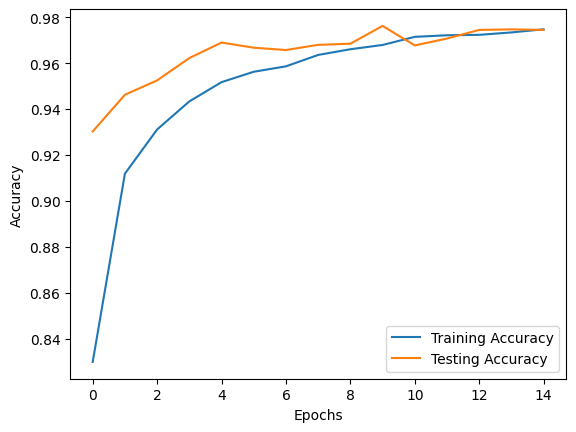

In [20]:
plt.plot(results.history['accuracy'], label = 'Training Accuracy')
plt.plot(results.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

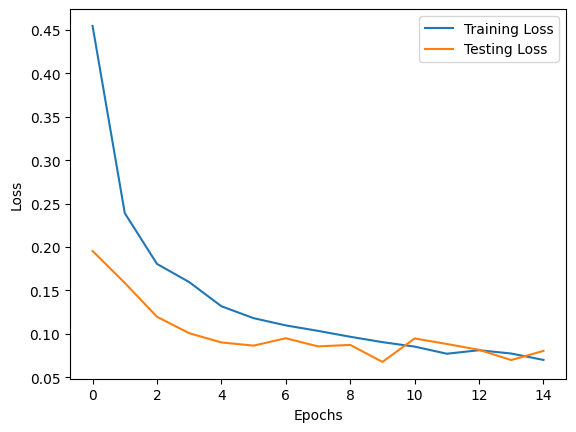

In [21]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']
[0 1 3 3 3 0 3 2 3 2 2 2 0 1 2 0 1 3 2 2 2 3 0 1 2] 

[[9.9999988e-01 5.9980302e-08 1.7275296e-10 2.7854667e-12]
 [6.2963981e-03 9.9369144e-01 1.2202107e-05 8.4520516e-11]
 [2.8654028e-20 6.0890936e-23 7.0732257e-25 1.0000000e+00]
 [7.6715985e-23 1.2906632e-25 7.2358271e-25 1.0000000e+00]
 [6.4644871e-26 1.7626785e-28 4.8250176e-30 1.0000000e+00]
 [9.8030978e-01 1.9423619e-02 1.6022410e-04 1.0641587e-04]
 [2.2130161e-32 1.5125382e-35 5.9703101e-33 1.0000000e+00]
 [1.1815947e-05 7.9840915e-03 9.9199778e-01 6.2720278e-06]
 [2.1111949e-21 4.8737793e-23 2.1902147e-24 1.0000000e+00]
 [3.4345089e-11 2.8163406e-05 9.9997187e-01 4.4112961e-13]
 [2.8595153e-07 1.4249093e-04 9.9985731e-01 3.9263531e-10]
 [4.9623311e-02 1.2168372e-03 9.4908249e-01 7.7371995e-05]
 [1.0000000e+00 4.1287538e-09 3.2591851e-10 6.5360299e-13]
 [7.7962160e-02 9.1830039e-01 3.7334680e-03 3.9729498e-06]
 [2.7109837e-04 4.7828481e-04 9.9924695e-01 3.6238721e-06

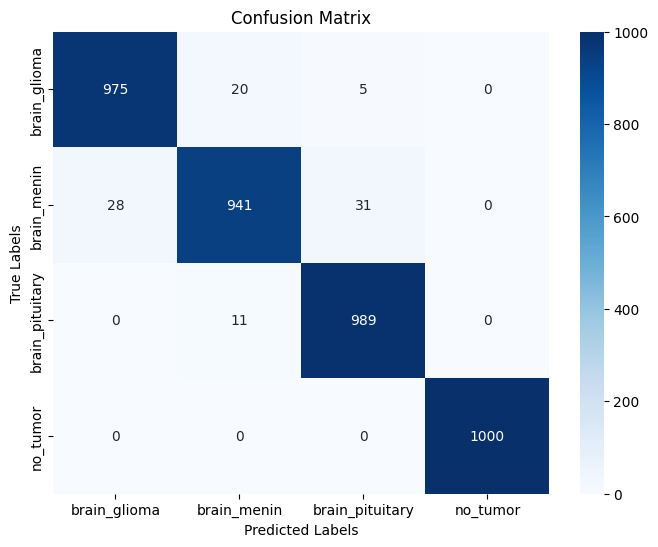

95.0 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.94      0.95      1000
           2       0.96      0.99      0.98      1000
           3       1.00      1.00      1.00      1000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss

# your existing code
print(classes)
print(y_test[:25], '\n')
print(y_pred[:25], '\n')

predict = []
for i in range(len(y_pred)):
    predict.append(np.argmax(y_pred[i]))

print(predict[:25], '\n')

cm = confusion_matrix(y_test, predict)
print(cm, '\n')

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

zol = zero_one_loss(y_test, predict, normalize=False)
print(zol, '\n')

cr = classification_report(y_test, predict)
print(cr)

<Figure size 500x500 with 0 Axes>

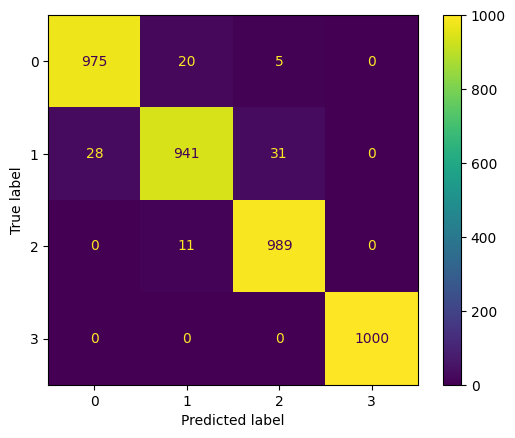

In [23]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

<Axes: ylabel='count'>

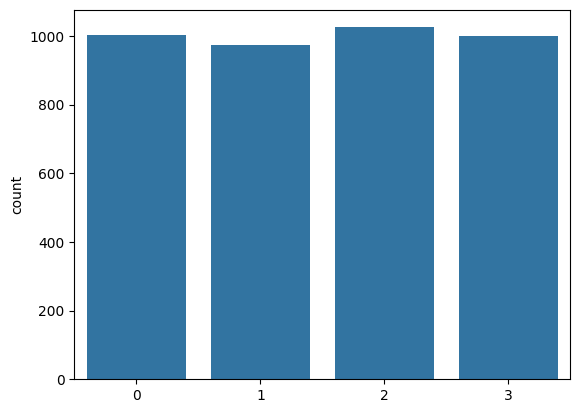

In [24]:
sb.countplot(x = predict)

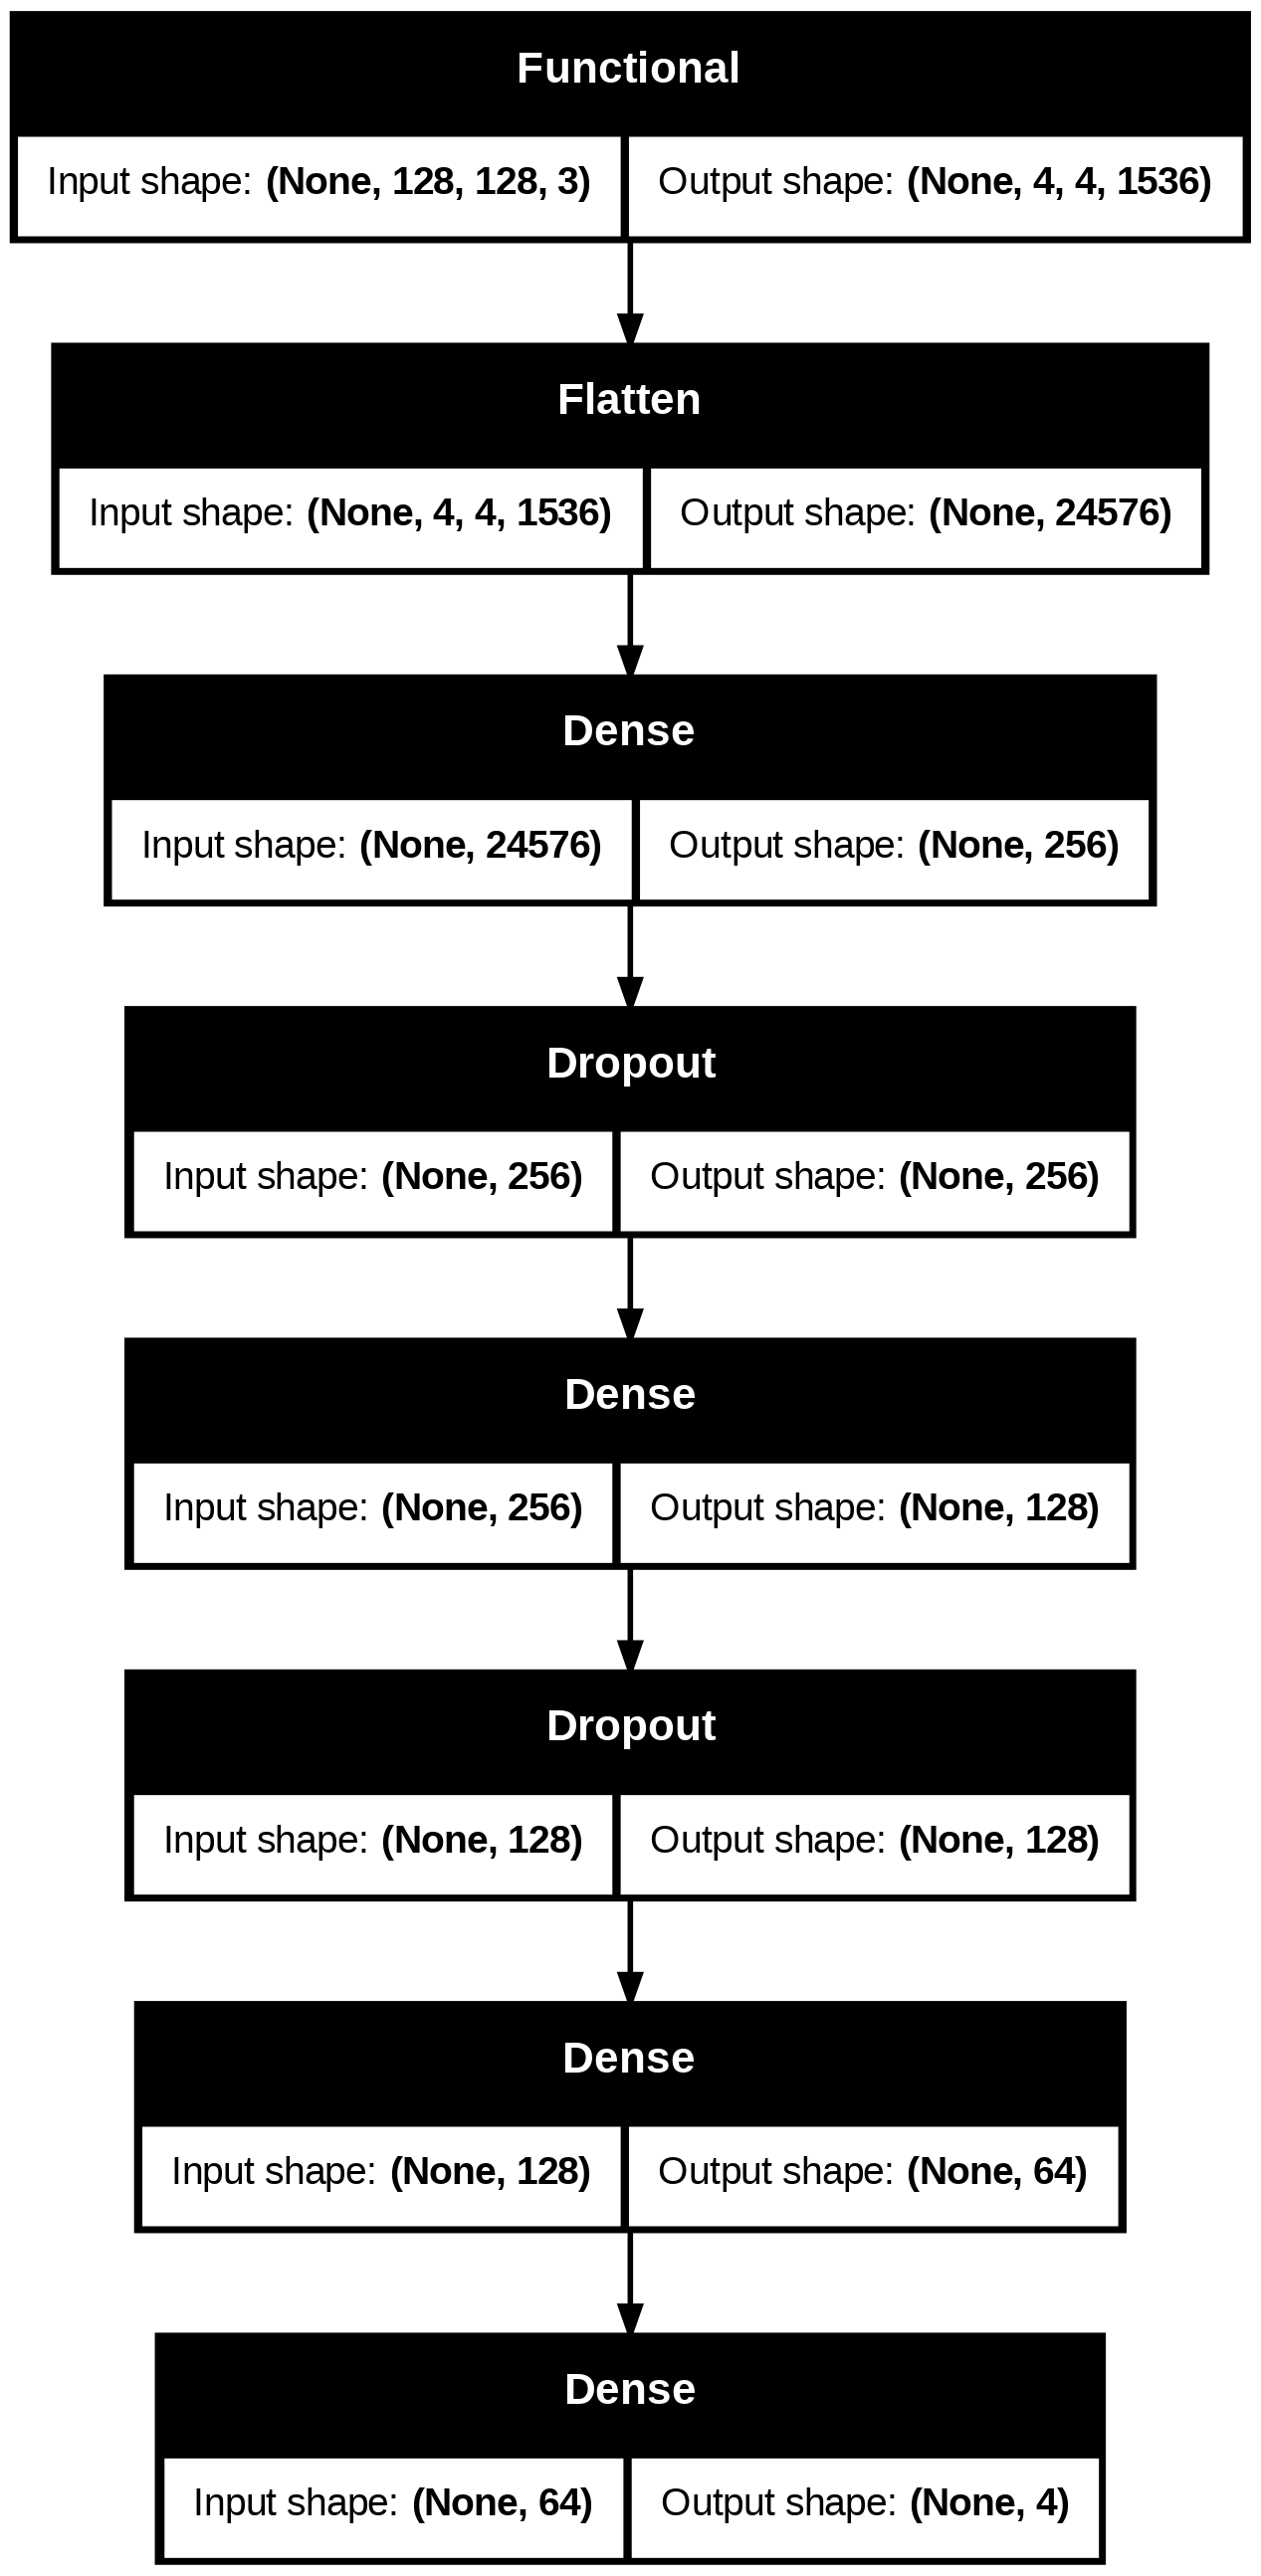

In [25]:
plot_model(model, show_shapes = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
[[9.9941945e-01 5.7872437e-04 1.4576913e-06 4.5694171e-07]]
['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


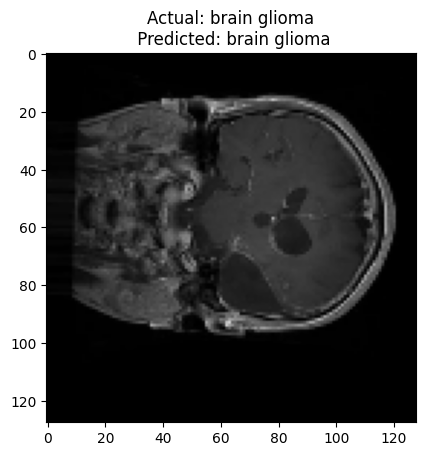

In [26]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

test_img_path = './image_dataset_(Brain)/test/brain_glioma/brain_glioma_4736.jpg'

test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (IMGSIZE, IMGSIZE))

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

test_img = test_img[tf.newaxis, ...]
test_predict = model.predict(test_img)

# Extract actual label from file name
filename = test_img_path.split(os.path.sep)[-1]
str1 = filename.split('_')[0]
str2 = filename.split('_')[1]

# Extract predicted class
predicted_class = classes[np.argmax(test_predict)]
str3 = predicted_class.split('_')[0] + ' ' + predicted_class.split('_')[1]

plt.title('Actual: ' + str1 + ' ' + str2 + '\n Predicted: ' + str3)

print(test_predict)
print(classes)
plt.show()